In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    months_df = pd.get_dummies(join.index.month, prefix='month')
    months_df.index=join.index
    join = pd.concat([join, months_df], axis=1)
    reactor_list.append(join)

In [5]:
reactor_list[0]

,SVI,Temperature,F_M - A,Sludge Age - A,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-02,84.365325,21.985,0.18,3.78,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,94.541139,21.740,0.21,3.82,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,97.402597,21.815,0.21,3.40,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,107.937685,21.890,0.23,3.70,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,147.453083,22.535,0.26,2.91,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,154.702970,22.660,0.26,2.82,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=2, binary=True)

In [7]:
X.shape

(16064, 2, 16)

In [8]:
X[0]

array([[90.94368341, 22.03      ,  0.23      ,  3.44      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [84.36532508, 21.985     ,  0.18      ,  3.78      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [9]:
Y[0]

array([1.])

In [43]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)


100%|██████████| 10/10 [00:00<00:00, 141.38it/s]


Epoch 1/3
14396/14396 [==============================] - 20s 1ms/step - loss: 0.5655 - binary_accuracy: 0.6908
Epoch 2/3
14396/14396 [==============================] - 16s 1ms/step - loss: 0.5111 - binary_accuracy: 0.7230
Epoch 3/3
14396/14396 [==============================] - 16s 1ms/step - loss: 0.4976 - binary_accuracy: 0.7316


In [60]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [111]:
def threshold_for_max_f1(y_real, y_predict):
    f1_vals = []
    for i in range(1, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
        y_real = Ytest.astype(int)
        
        f1 = km.results(y_real, y_predict, binary=True)[3]
        f1_vals.append(f1)
    print(f1_vals)
    return (f1_vals.index(max(f1_vals))+1)/100
    
    

In [112]:
threshold = threshold_for_max_f1(y_real, y_predict)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

[0.007722007722007722, 0.011560693641618497, 0.015384615384615384, 0.022988505747126436, 0.03802281368821293, 0.04914933837429111, 0.04914933837429111, 0.05639097744360902, 0.06367041198501873, 0.07806691449814127, 0.09208103130755066, 0.09506398537477148, 0.10869565217391304, 0.10869565217391304, 0.12567324955116696, 0.13214285714285715, 0.15520282186948853, 0.1681260945709282, 0.1840277777777778, 0.1899827288428325, 0.20240137221269297, 0.22335025380710657, 0.24080267558528431, 0.25412541254125415, 0.26143790849673204, 0.27419354838709675, 0.2852564102564103, 0.3118110236220472, 0.32868217054263565, 0.3460949464012251, 0.350609756097561, 0.36771300448430494, 0.38360175695461196, 0.3819241982507289, 0.3971223021582733, 0.40567375886524826, 0.413986013986014, 0.4408163265306122, 0.4574468085106383, 0.4742268041237113, 0.5012531328320803, 0.5249088699878494, 0.5271867612293145, 0.5393518518518519, 0.5559322033898305, 0.5625692137320044, 0.5736095965103599, 0.5830653804930334, 0.58078141

In [109]:
threshold

0.59

In [110]:
results = km.results(y_real, y_predict, binary=True)
results

(0.714375, 0.6957364341085271, 0.5447647951441578, 0.611063829787234)

In [54]:
classes = ['High_svi', 'Low_svi']

In [55]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[450  66]
 [535 549]]


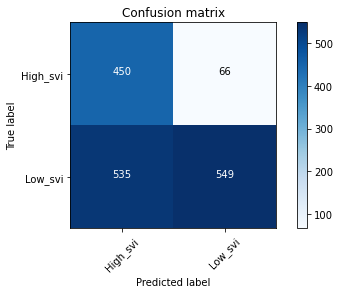

In [56]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [65]:
results = km.results(y_real, y_predict, binary=True)

In [66]:
results

(0.393125, 0.998062015503876, 0.3468013468013468, 0.5147426286856571)

In [20]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [21]:
auc(fpr, tpr)

0.8705271651425497

Text(0.5, 1.0, 'ROC curve')

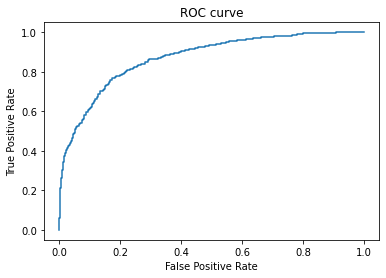

In [22]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [34]:
results_list = []
steps_in = 11
steps_out = 11
for i in range(1, steps_in):
    for j in range(1, steps_out):
        X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
        X_normalize, Y_normalize, scalers = km.normalize(X, Y)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
        model.fit(Xtrain, ytrain, epochs=2, batch_size=10, shuffle=True)
        Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
        y_predict = np.rint(Yhat).astype(int)
        y_real = Ytest.astype(int)
        results_list.append(km.results(y_real, y_predict))
    


100%|██████████| 1/1 [00:00<00:00, 227.01it/s]


Epoch 1/2
12854/12854 [==============================] - 6s 436us/step - loss: 0.6416
Epoch 2/2
12854/12854 [==============================] - 4s 319us/step - loss: 0.6118


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 275.33it/s]


Epoch 1/2
12851/12851 [==============================] - 7s 510us/step - loss: 0.6482
Epoch 2/2
12851/12851 [==============================] - 4s 331us/step - loss: 0.6164


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 265.53it/s]


Epoch 1/2
12848/12848 [==============================] - 5s 399us/step - loss: 0.6425
Epoch 2/2
12848/12848 [==============================] - 4s 321us/step - loss: 0.6155


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 253.63it/s]


Epoch 1/2
12844/12844 [==============================] - 5s 390us/step - loss: 0.6470
Epoch 2/2
12844/12844 [==============================] - 4s 348us/step - loss: 0.6156


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 220.71it/s]


Epoch 1/2
12841/12841 [==============================] - 5s 400us/step - loss: 0.6448
Epoch 2/2
12841/12841 [==============================] - 4s 296us/step - loss: 0.6147


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 249.19it/s]


Epoch 1/2
12838/12838 [==============================] - 7s 511us/step - loss: 0.6447
Epoch 2/2
12838/12838 [==============================] - 4s 337us/step - loss: 0.6151


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 243.49it/s]


Epoch 1/2
12835/12835 [==============================] - 5s 409us/step - loss: 0.6486
Epoch 2/2
12835/12835 [==============================] - 4s 295us/step - loss: 0.6172


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 190.04it/s]


Epoch 1/2
12832/12832 [==============================] - 6s 441us/step - loss: 0.6427
Epoch 2/2
12832/12832 [==============================] - 4s 298us/step - loss: 0.6161


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 246.38it/s]


Epoch 1/2
12828/12828 [==============================] - 6s 500us/step - loss: 0.6460
Epoch 2/2
12828/12828 [==============================] - 4s 286us/step - loss: 0.6157


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 255.88it/s]


Epoch 1/2
12825/12825 [==============================] - 6s 471us/step - loss: 0.6457
Epoch 2/2
12825/12825 [==============================] - 4s 322us/step - loss: 0.6167


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 2/2 [00:00<00:00, 209.79it/s]


Epoch 1/2
12851/12851 [==============================] - 7s 518us/step - loss: 0.6349
Epoch 2/2
12851/12851 [==============================] - 5s 393us/step - loss: 0.5987


100%|██████████| 2/2 [00:00<00:00, 174.14it/s]


Epoch 1/2
12848/12848 [==============================] - 7s 513us/step - loss: 0.6468
Epoch 2/2
12848/12848 [==============================] - 5s 388us/step - loss: 0.6094


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 2/2 [00:00<00:00, 248.45it/s]


Epoch 1/2
12844/12844 [==============================] - 6s 504us/step - loss: 0.6402
Epoch 2/2
12844/12844 [==============================] - 5s 388us/step - loss: 0.6039


100%|██████████| 2/2 [00:00<00:00, 275.94it/s]


Epoch 1/2
12841/12841 [==============================] - 6s 500us/step - loss: 0.6387
Epoch 2/2
12841/12841 [==============================] - 5s 381us/step - loss: 0.6089


100%|██████████| 2/2 [00:00<00:00, 287.85it/s]


Epoch 1/2
12838/12838 [==============================] - 7s 508us/step - loss: 0.6392
Epoch 2/2
12838/12838 [==============================] - 5s 371us/step - loss: 0.6048


100%|██████████| 2/2 [00:00<00:00, 286.82it/s]


Epoch 1/2
12835/12835 [==============================] - 6s 501us/step - loss: 0.6379
Epoch 2/2
12835/12835 [==============================] - 5s 392us/step - loss: 0.6057


100%|██████████| 2/2 [00:00<00:00, 289.73it/s]


Epoch 1/2
12832/12832 [==============================] - 7s 541us/step - loss: 0.6358
Epoch 2/2
12832/12832 [==============================] - 6s 483us/step - loss: 0.6040


100%|██████████| 2/2 [00:00<00:00, 173.51it/s]


Epoch 1/2
12828/12828 [==============================] - 7s 520us/step - loss: 0.6381
Epoch 2/2
12828/12828 [==============================] - 5s 396us/step - loss: 0.6047


100%|██████████| 2/2 [00:00<00:00, 286.57it/s]


Epoch 1/2
12825/12825 [==============================] - 6s 491us/step - loss: 0.6367
Epoch 2/2
12825/12825 [==============================] - 5s 377us/step - loss: 0.6093


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 2/2 [00:00<00:00, 289.55it/s]


Epoch 1/2
12822/12822 [==============================] - 7s 511us/step - loss: 0.6361
Epoch 2/2
12822/12822 [==============================] - 5s 395us/step - loss: 0.6118


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 3/3 [00:00<00:00, 178.99it/s]


Epoch 1/2
12848/12848 [==============================] - 10s 750us/step - loss: 0.6268
Epoch 2/2
12848/12848 [==============================] - 7s 539us/step - loss: 0.5644


100%|██████████| 3/3 [00:00<00:00, 237.04it/s]


Epoch 1/2
12844/12844 [==============================] - 9s 726us/step - loss: 0.6344
Epoch 2/2
12844/12844 [==============================] - 7s 556us/step - loss: 0.6049


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 3/3 [00:00<00:00, 265.79it/s]


Epoch 1/2
12841/12841 [==============================] - 8s 657us/step - loss: 0.6300
Epoch 2/2
12841/12841 [==============================] - 7s 571us/step - loss: 0.5981


100%|██████████| 3/3 [00:00<00:00, 205.82it/s]


Epoch 1/2
12838/12838 [==============================] - 8s 613us/step - loss: 0.6441
Epoch 2/2
12838/12838 [==============================] - 7s 545us/step - loss: 0.6015


100%|██████████| 3/3 [00:00<00:00, 239.71it/s]


Epoch 1/2
12835/12835 [==============================] - 8s 633us/step - loss: 0.6320
Epoch 2/2
12835/12835 [==============================] - 7s 513us/step - loss: 0.6067


100%|██████████| 3/3 [00:00<00:00, 264.06it/s]


Epoch 1/2
12832/12832 [==============================] - 8s 643us/step - loss: 0.6321
Epoch 2/2
12832/12832 [==============================] - 6s 479us/step - loss: 0.6041


100%|██████████| 3/3 [00:00<00:00, 233.51it/s]


Epoch 1/2
12828/12828 [==============================] - 8s 617us/step - loss: 0.6326
Epoch 2/2
12828/12828 [==============================] - 6s 500us/step - loss: 0.5966


100%|██████████| 3/3 [00:00<00:00, 278.52it/s]


Epoch 1/2
12825/12825 [==============================] - 8s 620us/step - loss: 0.6296
Epoch 2/2
12825/12825 [==============================] - 6s 493us/step - loss: 0.6003


100%|██████████| 3/3 [00:00<00:00, 266.60it/s]


Epoch 1/2
12822/12822 [==============================] - 9s 713us/step - loss: 0.6337
Epoch 2/2
12822/12822 [==============================] - 6s 492us/step - loss: 0.6117


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 3/3 [00:00<00:00, 237.24it/s]


Epoch 1/2
12819/12819 [==============================] - 8s 652us/step - loss: 0.6352
Epoch 2/2
12819/12819 [==============================] - 6s 505us/step - loss: 0.6085


100%|██████████| 4/4 [00:00<00:00, 197.01it/s]


Epoch 1/2
12844/12844 [==============================] - 9s 713us/step - loss: 0.6312
Epoch 2/2
12844/12844 [==============================] - 8s 648us/step - loss: 0.5683


100%|██████████| 4/4 [00:00<00:00, 243.06it/s]


Epoch 1/2
12841/12841 [==============================] - 9s 688us/step - loss: 0.6310
Epoch 2/2
12841/12841 [==============================] - 8s 629us/step - loss: 0.5828


100%|██████████| 4/4 [00:00<00:00, 231.53it/s]


Epoch 1/2
12838/12838 [==============================] - 10s 742us/step - loss: 0.6236
Epoch 2/2
12838/12838 [==============================] - 8s 611us/step - loss: 0.5793


100%|██████████| 4/4 [00:00<00:00, 239.62it/s]


Epoch 1/2
12835/12835 [==============================] - 9s 674us/step - loss: 0.6308
Epoch 2/2
12835/12835 [==============================] - 7s 555us/step - loss: 0.5931


100%|██████████| 4/4 [00:00<00:00, 169.47it/s]


Epoch 1/2
12832/12832 [==============================] - 9s 714us/step - loss: 0.6433
Epoch 2/2
12832/12832 [==============================] - 9s 664us/step - loss: 0.6030


100%|██████████| 4/4 [00:00<00:00, 205.54it/s]


Epoch 1/2
12828/12828 [==============================] - 9s 685us/step - loss: 0.6327
Epoch 2/2
12828/12828 [==============================] - 7s 570us/step - loss: 0.6000


100%|██████████| 4/4 [00:00<00:00, 235.52it/s]


Epoch 1/2
12825/12825 [==============================] - 10s 801us/step - loss: 0.6256
Epoch 2/2
12825/12825 [==============================] - 8s 649us/step - loss: 0.6014


100%|██████████| 4/4 [00:00<00:00, 252.16it/s]


Epoch 1/2
12822/12822 [==============================] - 9s 706us/step - loss: 0.6299
Epoch 2/2
12822/12822 [==============================] - 7s 574us/step - loss: 0.5955


100%|██████████| 4/4 [00:00<00:00, 229.12it/s]


Epoch 1/2
12819/12819 [==============================] - 8s 658us/step - loss: 0.6306
Epoch 2/2
12819/12819 [==============================] - 7s 548us/step - loss: 0.6026


100%|██████████| 4/4 [00:00<00:00, 185.37it/s]


Epoch 1/2
12816/12816 [==============================] - 8s 658us/step - loss: 0.6282
Epoch 2/2
12816/12816 [==============================] - 7s 552us/step - loss: 0.6037


100%|██████████| 5/5 [00:00<00:00, 253.54it/s]


Epoch 1/2
12841/12841 [==============================] - 10s 750us/step - loss: 0.6248
Epoch 2/2
12841/12841 [==============================] - 8s 659us/step - loss: 0.5601


100%|██████████| 5/5 [00:00<00:00, 173.80it/s]


Epoch 1/2
12838/12838 [==============================] - 10s 758us/step - loss: 0.6349
Epoch 2/2
12838/12838 [==============================] - 8s 656us/step - loss: 0.5726


100%|██████████| 5/5 [00:00<00:00, 206.93it/s]


Epoch 1/2
12835/12835 [==============================] - 11s 869us/step - loss: 0.6309
Epoch 2/2
12835/12835 [==============================] - 8s 656us/step - loss: 0.5778


100%|██████████| 5/5 [00:00<00:00, 234.32it/s]


Epoch 1/2
12832/12832 [==============================] - 10s 783us/step - loss: 0.6279
Epoch 2/2
12832/12832 [==============================] - 9s 675us/step - loss: 0.5894


100%|██████████| 5/5 [00:00<00:00, 197.28it/s]


Epoch 1/2
12828/12828 [==============================] - 11s 863us/step - loss: 0.6291
Epoch 2/2
12828/12828 [==============================] - 9s 711us/step - loss: 0.5790


100%|██████████| 5/5 [00:00<00:00, 198.43it/s]


Epoch 1/2
12825/12825 [==============================] - 10s 802us/step - loss: 0.6217
Epoch 2/2
12825/12825 [==============================] - 9s 673us/step - loss: 0.5734


100%|██████████| 5/5 [00:00<00:00, 244.59it/s]


Epoch 1/2
12822/12822 [==============================] - 11s 832us/step - loss: 0.6292
Epoch 2/2
12822/12822 [==============================] - 9s 675us/step - loss: 0.5932


100%|██████████| 5/5 [00:00<00:00, 223.02it/s]


Epoch 1/2
12819/12819 [==============================] - 10s 801us/step - loss: 0.6385
Epoch 2/2
12819/12819 [==============================] - 9s 725us/step - loss: 0.6063


100%|██████████| 5/5 [00:00<00:00, 180.38it/s]


Epoch 1/2
12816/12816 [==============================] - 10s 790us/step - loss: 0.6365
Epoch 2/2
12816/12816 [==============================] - 9s 678us/step - loss: 0.5968


100%|██████████| 5/5 [00:00<00:00, 269.17it/s]


Epoch 1/2
12812/12812 [==============================] - 11s 894us/step - loss: 0.6331
Epoch 2/2
12812/12812 [==============================] - 11s 839us/step - loss: 0.6049


100%|██████████| 6/6 [00:00<00:00, 137.74it/s]


Epoch 1/2
12838/12838 [==============================] - 12s 933us/step - loss: 0.6142
Epoch 2/2
12838/12838 [==============================] - 10s 776us/step - loss: 0.5313


100%|██████████| 6/6 [00:00<00:00, 143.20it/s]


Epoch 1/2
12835/12835 [==============================] - 11s 884us/step - loss: 0.6314
Epoch 2/2
12835/12835 [==============================] - 10s 772us/step - loss: 0.5649


100%|██████████| 6/6 [00:00<00:00, 211.01it/s]


Epoch 1/2
12832/12832 [==============================] - 13s 977us/step - loss: 0.6293
Epoch 2/2
12832/12832 [==============================] - 10s 752us/step - loss: 0.5749


100%|██████████| 6/6 [00:00<00:00, 222.22it/s]


Epoch 1/2
12828/12828 [==============================] - 11s 887us/step - loss: 0.6199
Epoch 2/2
12828/12828 [==============================] - 10s 764us/step - loss: 0.5860


100%|██████████| 6/6 [00:00<00:00, 223.91it/s]


Epoch 1/2
12825/12825 [==============================] - 12s 902us/step - loss: 0.6236
Epoch 2/2
12825/12825 [==============================] - 10s 813us/step - loss: 0.5679


100%|██████████| 6/6 [00:00<00:00, 156.85it/s]


Epoch 1/2
12822/12822 [==============================] - 11s 887us/step - loss: 0.6269
Epoch 2/2
12822/12822 [==============================] - 10s 760us/step - loss: 0.5773


100%|██████████| 6/6 [00:00<00:00, 205.18it/s]


Epoch 1/2
12819/12819 [==============================] - 12s 901us/step - loss: 0.6246
Epoch 2/2
12819/12819 [==============================] - 11s 824us/step - loss: 0.5843


100%|██████████| 6/6 [00:00<00:00, 150.35it/s]


Epoch 1/2
12816/12816 [==============================] - 12s 927us/step - loss: 0.6324
Epoch 2/2
12816/12816 [==============================] - 10s 800us/step - loss: 0.5949


100%|██████████| 6/6 [00:00<00:00, 223.04it/s]


Epoch 1/2
12812/12812 [==============================] - 11s 874us/step - loss: 0.6283
Epoch 2/2
12812/12812 [==============================] - 10s 757us/step - loss: 0.5901


100%|██████████| 6/6 [00:00<00:00, 166.00it/s]


Epoch 1/2
12809/12809 [==============================] - 12s 934us/step - loss: 0.6262
Epoch 2/2
12809/12809 [==============================] - 10s 760us/step - loss: 0.5985


100%|██████████| 7/7 [00:00<00:00, 180.59it/s]


Epoch 1/2
12835/12835 [==============================] - 13s 975us/step - loss: 0.6277
Epoch 2/2
12835/12835 [==============================] - 11s 852us/step - loss: 0.5780


100%|██████████| 7/7 [00:00<00:00, 224.70it/s]


Epoch 1/2
12832/12832 [==============================] - 13s 1ms/step - loss: 0.6273
Epoch 2/2
12832/12832 [==============================] - 12s 915us/step - loss: 0.5545


100%|██████████| 7/7 [00:00<00:00, 213.94it/s]


Epoch 1/2
12828/12828 [==============================] - 13s 1ms/step - loss: 0.6193
Epoch 2/2
12828/12828 [==============================] - 11s 877us/step - loss: 0.5749


100%|██████████| 7/7 [00:00<00:00, 183.74it/s]


Epoch 1/2
12825/12825 [==============================] - 14s 1ms/step - loss: 0.6347
Epoch 2/2
12825/12825 [==============================] - 11s 894us/step - loss: 0.5803


100%|██████████| 7/7 [00:00<00:00, 195.43it/s]


Epoch 1/2
12822/12822 [==============================] - 12s 963us/step - loss: 0.6266
Epoch 2/2
12822/12822 [==============================] - 11s 849us/step - loss: 0.5732


100%|██████████| 7/7 [00:00<00:00, 210.72it/s]


Epoch 1/2
12819/12819 [==============================] - 13s 1ms/step - loss: 0.6336
Epoch 2/2
12819/12819 [==============================] - 11s 843us/step - loss: 0.5862


100%|██████████| 7/7 [00:00<00:00, 211.55it/s]


Epoch 1/2
12816/12816 [==============================] - 12s 930us/step - loss: 0.6278
Epoch 2/2
12816/12816 [==============================] - 11s 823us/step - loss: 0.5901


100%|██████████| 7/7 [00:00<00:00, 206.31it/s]


Epoch 1/2
12812/12812 [==============================] - 12s 943us/step - loss: 0.6298
Epoch 2/2
12812/12812 [==============================] - 11s 823us/step - loss: 0.5991


100%|██████████| 7/7 [00:00<00:00, 209.30it/s]


Epoch 1/2
12809/12809 [==============================] - 12s 949us/step - loss: 0.6288
Epoch 2/2
12809/12809 [==============================] - 10s 814us/step - loss: 0.5924


100%|██████████| 7/7 [00:00<00:00, 223.25it/s]


Epoch 1/2
12806/12806 [==============================] - 12s 932us/step - loss: 0.6277
Epoch 2/2
12806/12806 [==============================] - 12s 966us/step - loss: 0.6013


100%|██████████| 8/8 [00:00<00:00, 169.19it/s]


Epoch 1/2
12832/12832 [==============================] - 13s 1ms/step - loss: 0.6215
Epoch 2/2
12832/12832 [==============================] - 12s 930us/step - loss: 0.5407


100%|██████████| 8/8 [00:00<00:00, 168.24it/s]


Epoch 1/2
12828/12828 [==============================] - 13s 1ms/step - loss: 0.6314
Epoch 2/2
12828/12828 [==============================] - 12s 922us/step - loss: 0.5730


100%|██████████| 8/8 [00:00<00:00, 168.50it/s]


Epoch 1/2
12825/12825 [==============================] - 13s 1ms/step - loss: 0.6156
Epoch 2/2
12825/12825 [==============================] - 13s 979us/step - loss: 0.5631


100%|██████████| 8/8 [00:00<00:00, 151.65it/s]


Epoch 1/2
12822/12822 [==============================] - 14s 1ms/step - loss: 0.6248
Epoch 2/2
12822/12822 [==============================] - 13s 1ms/step - loss: 0.5749


100%|██████████| 8/8 [00:00<00:00, 148.68it/s]


Epoch 1/2
12819/12819 [==============================] - 14s 1ms/step - loss: 0.6265
Epoch 2/2
12819/12819 [==============================] - 13s 975us/step - loss: 0.5730


100%|██████████| 8/8 [00:00<00:00, 149.53it/s]


Epoch 1/2
12816/12816 [==============================] - 14s 1ms/step - loss: 0.6276
Epoch 2/2
12816/12816 [==============================] - 12s 966us/step - loss: 0.5843


100%|██████████| 8/8 [00:00<00:00, 135.59it/s]


Epoch 1/2
12812/12812 [==============================] - 13s 1ms/step - loss: 0.6193
Epoch 2/2
12812/12812 [==============================] - 12s 931us/step - loss: 0.5782


100%|██████████| 8/8 [00:00<00:00, 136.32it/s]


Epoch 1/2
12809/12809 [==============================] - 14s 1ms/step - loss: 0.6261
Epoch 2/2
12809/12809 [==============================] - 12s 938us/step - loss: 0.5720


100%|██████████| 8/8 [00:00<00:00, 157.69it/s]


Epoch 1/2
12806/12806 [==============================] - 13s 1ms/step - loss: 0.6222
Epoch 2/2
12806/12806 [==============================] - 12s 923us/step - loss: 0.5761


100%|██████████| 8/8 [00:00<00:00, 161.55it/s]


Epoch 1/2
12803/12803 [==============================] - 13s 1ms/step - loss: 0.6289
Epoch 2/2
12803/12803 [==============================] - 12s 912us/step - loss: 0.5915


100%|██████████| 9/9 [00:00<00:00, 205.51it/s]


Epoch 1/2
12828/12828 [==============================] - 14s 1ms/step - loss: 0.6236
Epoch 2/2
12828/12828 [==============================] - 13s 1ms/step - loss: 0.5432


100%|██████████| 9/9 [00:00<00:00, 161.71it/s]


Epoch 1/2
12825/12825 [==============================] - 15s 1ms/step - loss: 0.6230
Epoch 2/2
12825/12825 [==============================] - 13s 1ms/step - loss: 0.5543


100%|██████████| 9/9 [00:00<00:00, 146.40it/s]


Epoch 1/2
12822/12822 [==============================] - 14s 1ms/step - loss: 0.6229
Epoch 2/2
12822/12822 [==============================] - 16s 1ms/step - loss: 0.5575


100%|██████████| 9/9 [00:00<00:00, 274.84it/s]


Epoch 1/2
12819/12819 [==============================] - 1457s 114ms/step - loss: 0.6131
Epoch 2/2
12819/12819 [==============================] - 76s 6ms/step - loss: 0.5444


100%|██████████| 9/9 [00:00<00:00, 67.37it/s]


Epoch 1/2
12816/12816 [==============================] - 18s 1ms/step - loss: 0.6253
Epoch 2/2
12816/12816 [==============================] - 14s 1ms/step - loss: 0.5801


100%|██████████| 9/9 [00:00<00:00, 229.06it/s]


Epoch 1/2
12812/12812 [==============================] - 17s 1ms/step - loss: 0.6182
Epoch 2/2
12812/12812 [==============================] - 16s 1ms/step - loss: 0.5719


100%|██████████| 9/9 [00:00<00:00, 165.54it/s]


Epoch 1/2
12809/12809 [==============================] - 15s 1ms/step - loss: 0.6211
Epoch 2/2
12809/12809 [==============================] - 13s 1ms/step - loss: 0.5720


100%|██████████| 9/9 [00:00<00:00, 225.65it/s]


Epoch 1/2
12806/12806 [==============================] - 14s 1ms/step - loss: 0.6240
Epoch 2/2
12806/12806 [==============================] - 13s 1ms/step - loss: 0.5703


100%|██████████| 9/9 [00:00<00:00, 222.42it/s]


Epoch 1/2
12803/12803 [==============================] - 15s 1ms/step - loss: 0.6279
Epoch 2/2
12803/12803 [==============================] - 14s 1ms/step - loss: 0.5976


100%|██████████| 9/9 [00:00<00:00, 220.37it/s]


Epoch 1/2
12800/12800 [==============================] - 15s 1ms/step - loss: 0.6289
Epoch 2/2
12800/12800 [==============================] - 14s 1ms/step - loss: 0.5868


100%|██████████| 10/10 [00:00<00:00, 149.68it/s]


Epoch 1/2
12825/12825 [==============================] - 16s 1ms/step - loss: 0.6278
Epoch 2/2
12825/12825 [==============================] - 15s 1ms/step - loss: 0.5346


100%|██████████| 10/10 [00:00<00:00, 195.28it/s]


Epoch 1/2
12822/12822 [==============================] - 25s 2ms/step - loss: 0.6251
Epoch 2/2
12822/12822 [==============================] - 18s 1ms/step - loss: 0.5602


100%|██████████| 10/10 [00:00<00:00, 131.37it/s]


Epoch 1/2
12819/12819 [==============================] - 21s 2ms/step - loss: 0.6201
Epoch 2/2
12819/12819 [==============================] - 16s 1ms/step - loss: 0.5459


100%|██████████| 10/10 [00:00<00:00, 246.11it/s]


Epoch 1/2
12816/12816 [==============================] - 18s 1ms/step - loss: 0.6387
Epoch 2/2
12816/12816 [==============================] - 16s 1ms/step - loss: 0.5811


100%|██████████| 10/10 [00:00<00:00, 233.01it/s]


Epoch 1/2
12812/12812 [==============================] - 18s 1ms/step - loss: 0.6144
Epoch 2/2
12812/12812 [==============================] - 16s 1ms/step - loss: 0.5597


100%|██████████| 10/10 [00:00<00:00, 96.13it/s]


Epoch 1/2
12809/12809 [==============================] - 18s 1ms/step - loss: 0.6174
Epoch 2/2
12809/12809 [==============================] - 18s 1ms/step - loss: 0.5716


100%|██████████| 10/10 [00:00<00:00, 199.11it/s]


Epoch 1/2
12806/12806 [==============================] - 16s 1ms/step - loss: 0.6304
Epoch 2/2
12806/12806 [==============================] - 14s 1ms/step - loss: 0.5746


100%|██████████| 10/10 [00:00<00:00, 251.75it/s]


Epoch 1/2
12803/12803 [==============================] - 17s 1ms/step - loss: 0.6246
Epoch 2/2
12803/12803 [==============================] - 15s 1ms/step - loss: 0.5856


100%|██████████| 10/10 [00:00<00:00, 183.55it/s]


Epoch 1/2
12800/12800 [==============================] - 18s 1ms/step - loss: 0.6187
Epoch 2/2
12800/12800 [==============================] - 16s 1ms/step - loss: 0.5862


100%|██████████| 10/10 [00:00<00:00, 220.81it/s]


Epoch 1/2
12796/12796 [==============================] - 17s 1ms/step - loss: 0.6263
Epoch 2/2
12796/12796 [==============================] - 15s 1ms/step - loss: 0.5980


In [36]:
(unique, counts) = np.unique(ytrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [37]:
frequencies

array([[0.000e+00, 4.161e+03],
       [1.000e+00, 8.635e+03]])

In [38]:
#plot graph of a metric result for all n_step_in and n_step_out values
x=range(1, 11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(4):
    for i in range(10):
        y=[]
        for j in range (10):
            y.append(results_list[i*10:i*10+10][j][z])
        plt.plot(x, y, label=f'n_steps_in={i+1}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel(label[z])
    plt.title("Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
    plt.savefig(f"figures/Simple LSTM {label[z]}.png", bbox_inches="tight")
    plt.close()

In [40]:
#plot graph of all metric results for a n_step_in value
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(10):
    for i in range(4):
        y=[]
        for j in range (10):
            y.append(results_list[z*10:z*10+10][j][i])
        plt.plot(x, y, label=label[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel('Metric value')
    plt.title(f"Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
    plt.savefig(f"figures/Simple LSTM n_steps_in={z+1}.png", bbox_inches="tight")
    plt.close()